# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

8.0    5000
7.0    5000
6.0    5000
5.0    5000
3.0    5000
1.0    5000
0.0    5000
9.0    2500
4.0    2500
2.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

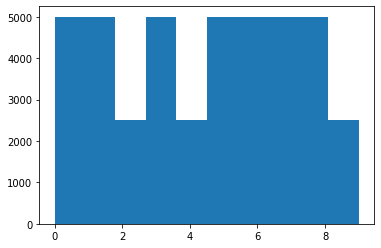

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## AutoEncoder

#### Load AE models weight

In [10]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [11]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [12]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

#### Train without data augumentation & Class weight

In [13]:
%%time

# train
saveDir = "../models/CNN/"
histories = []
class_weights_arr = [] # for calc class weight 
nb_classes = 10
predicts = np.zeros((10000, 10))
cv_acc = 0
cv_f1 = 0 

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model01 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # calculate class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train_),
                                                     y_train_)
    class_weights_arr.append(class_weights)
    class_weights = dict(enumerate(class_weights))

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_011_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    model01_history = model01.fit(x_train_, y_train_onehot,
                          batch_size=32,
                          epochs=400,
                          verbose=1,
                          validation_data=(x_valid_, y_valid_onehot),
                          callbacks=[es_cb, cp_cb],
                          class_weight=class_weights,
                          shuffle=True)
    
    # inference
    model01.load_weights(chkpt)
    scores = model01.evaluate(x_valid_, y_valid_onehot)
    
    # CV value
    cv_acc += scores[1]*100
    y_valid_pred =  model01.predict(x_valid_)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)
    cv_f1 += f1_score(y_valid_, y_valid_pred, average='macro')*100
    
    print(f'Score for fold {fold_no}: {model01.metrics_names[0]} of {scores[0]}; {model01.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model01.predict(x_test)
    predicts += predict
    
    histories.append(model01_history.history)
    fold_no += 1

C:\Users\12810649\AppData\Local\Continuum\anaconda3\envs\tf2.1-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[9. 9. 4. ... 0. 1. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/400
886/886 [==============================] - ETA: 0s - loss: 1.4815 - accuracy: 0.4740
Epoch 00001: val_loss improved from inf to 1.18299, saving model to ../models/CNN\Model_011_1_Best.hdf5
886/886 [==============================] - 6s 7ms/step - loss: 1.4815 - accuracy: 0.4740 - val_loss: 1.1830 - val_accuracy: 0.5738
Epoch 2/400
878/886 [============================>.] - ETA: 0s - loss: 1.0968 - accuracy: 0.6174
Epoch 00002: val_loss improved from 1.18299 to 1.13400, saving model to ../models/CNN\Model_011_1_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 1.0954 - accuracy: 0.6176 - val_loss: 1.1340 - val_accuracy: 0.5925
Epoch 3/400
876/886 [============================>.] - ETA: 0s - loss: 0.8961 - accuracy: 0.6881
Epoch 00003: val_loss improved from 1.13400 to 0.95631, saving model to ../models/CNN\Model_011_1_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 0.8959 - accuracy: 0.6880 - val_loss: 0.9563 - val_accuracy: 0.6

C:\Users\12810649\AppData\Local\Continuum\anaconda3\envs\tf2.1-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 1. 1. ... 0. 1. 6.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/400
877/886 [============================>.] - ETA: 0s - loss: 1.4769 - accuracy: 0.4762
Epoch 00001: val_loss improved from inf to 1.49876, saving model to ../models/CNN\Model_011_2_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 1.4735 - accuracy: 0.4772 - val_loss: 1.4988 - val_accuracy: 0.4958
Epoch 2/400
885/886 [============================>.] - ETA: 0s - loss: 1.0977 - accuracy: 0.6180
Epoch 00002: val_loss improved from 1.49876 to 1.23893, saving model to ../models/CNN\Model_011_2_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 1.0979 - accuracy: 0.6180 - val_loss: 1.2389 - val_accuracy: 0.5712
Epoch 3/400
886/886 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.6879
Epoch 00003: val_loss improved from 1.23893 to 0.94874, saving model to ../models/CNN\Model_011_2_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 0.9003 - accuracy: 0.6879 - val_loss: 0.9487 - val_accuracy: 0.6

C:\Users\12810649\AppData\Local\Continuum\anaconda3\envs\tf2.1-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 9. 9. ... 6. 1. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/400
886/886 [==============================] - ETA: 0s - loss: 1.4927 - accuracy: 0.4730
Epoch 00001: val_loss improved from inf to 1.96921, saving model to ../models/CNN\Model_011_3_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 1.4927 - accuracy: 0.4730 - val_loss: 1.9692 - val_accuracy: 0.4049
Epoch 2/400
884/886 [============================>.] - ETA: 0s - loss: 1.0955 - accuracy: 0.6164
Epoch 00002: val_loss improved from 1.96921 to 1.21233, saving model to ../models/CNN\Model_011_3_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 1.0952 - accuracy: 0.6166 - val_loss: 1.2123 - val_accuracy: 0.6117
Epoch 3/400
882/886 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.6805
Epoch 00003: val_loss improved from 1.21233 to 1.09126, saving model to ../models/CNN\Model_011_3_Best.hdf5
886/886 [==============================] - 5s 6ms/step - loss: 0.9174 - accuracy: 0.6805 - val_loss: 1.0913 - val_accuracy: 0.6

In [24]:
# print classs weight
ensemble_class_weights_arr = class_weights_arr
for class_weight_ in ensemble_class_weights_arr:
    print(dict(enumerate(class_weight_)))

{0: 0.85007500750075, 1: 0.8498200359928014, 2: 1.7006602641056423, 3: 0.85007500750075, 4: 1.7006602641056423, 5: 0.8498200359928014, 6: 0.85007500750075, 7: 0.8498200359928014, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.85007500750075, 1: 0.85007500750075, 2: 1.6996400719856029, 3: 0.8498200359928014, 4: 1.6996400719856029, 5: 0.85007500750075, 6: 0.85007500750075, 7: 0.85007500750075, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.8498500299940012, 1: 0.8501050105010501, 2: 1.6997000599880023, 3: 0.8501050105010501, 4: 1.6997000599880023, 5: 0.8501050105010501, 6: 0.8498500299940012, 7: 0.8501050105010501, 8: 0.8498500299940012, 9: 1.7007202881152461}


In [23]:
ensemble_histories = histories
ensemble_predicts = predicts
ensemble_predicts_ = ensemble_predicts / n_splits
y_pred = np.argmax(ensemble_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.86      0.92      0.89      1000
           2       0.62      0.74      0.67      1000
           3       0.58      0.71      0.64      1000
           4       0.84      0.59      0.69      1000
           5       0.75      0.71      0.73      1000
           6       0.80      0.82      0.81      1000
           7       0.85      0.83      0.84      1000
           8       0.91      0.85      0.88      1000
           9       0.93      0.79      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [14]:
print(f'CV ACC is {cv_acc//n_splits},n_splits CV macro F1 is {cv_f1//n_splits}')

CV ACC is 72.0,n_splits CV macro F1 is 71.0


#### Train with data augumentation & Class weight

In [15]:
%%time

# train
saveDir = "../models/CNN/"
histories = []
class_weights_arr = [] # for calc class weight 
nb_classes = 10
predicts = np.zeros((10000, 10))
cv_acc = 0
cv_f1 = 0 

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model02 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # calculate class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train_),
                                                     y_train_)
    class_weights_arr.append(class_weights)
    class_weights = dict(enumerate(class_weights))
    
    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_012_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     shear_range=0.2,
    horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    zoom_range=0.1
#     channel_shift_range=0.2
    )

    batch_size = 32
    train_datagenerator = train_datagen.flow(x_train_, y_train_onehot, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model02_history = model02.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  class_weight=class_weights,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model02.load_weights(chkpt)
    scores = model02.evaluate(x_valid_, y_valid_onehot)
    
    # CV value
    cv_acc += scores[1]*100
    y_valid_pred =  model02.predict(x_valid_)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)
    cv_f1 += f1_score(y_valid_, y_valid_pred, average='macro')*100
    
    print(f'Score for fold {fold_no}: {model02.metrics_names[0]} of {scores[0]}; {model02.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model02.predict(x_test)
    predicts += predict
    
    histories.append(model02_history.history)
    fold_no += 1

Instructions for updating:
Please use Model.fit, which supports generators.


C:\Users\12810649\AppData\Local\Continuum\anaconda3\envs\tf2.1-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 9. 9. ... 6. 1. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/400
881/885 [============================>.] - ETA: 0s - loss: 1.5489 - accuracy: 0.4511
Epoch 00001: val_loss improved from inf to 1.40215, saving model to ../models/CNN\Model_012_1_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.5483 - accuracy: 0.4514 - val_loss: 1.4022 - val_accuracy: 0.5147
Epoch 2/400
880/885 [============================>.] - ETA: 0s - loss: 1.2052 - accuracy: 0.5762
Epoch 00002: val_loss improved from 1.40215 to 1.24829, saving model to ../models/CNN\Model_012_1_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.2040 - accuracy: 0.5767 - val_loss: 1.2483 - val_accuracy: 0.5706
Epoch 3/400
884/885 [============================>.] - ETA: 0s - loss: 1.0280 - accuracy: 0.6433
Epoch 00003: val_loss improved from 1.24829 to 1.01831, saving model to ../models/CNN\Model_012_1_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.0278 - accuracy: 0.6432 - val_loss: 1.0183 - val_accuracy: 0.6

C:\Users\12810649\AppData\Local\Continuum\anaconda3\envs\tf2.1-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 9. 9. ... 5. 1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/400
881/885 [============================>.] - ETA: 0s - loss: 1.5519 - accuracy: 0.4482
Epoch 00001: val_loss improved from inf to 1.52417, saving model to ../models/CNN\Model_012_2_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.5508 - accuracy: 0.4488 - val_loss: 1.5242 - val_accuracy: 0.4839
Epoch 2/400
881/885 [============================>.] - ETA: 0s - loss: 1.1827 - accuracy: 0.5871
Epoch 00002: val_loss improved from 1.52417 to 1.10951, saving model to ../models/CNN\Model_012_2_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.1812 - accuracy: 0.5876 - val_loss: 1.1095 - val_accuracy: 0.6212
Epoch 3/400
883/885 [============================>.] - ETA: 0s - loss: 0.9933 - accuracy: 0.6542
Epoch 00003: val_loss did not improve from 1.10951
885/885 [==============================] - 8s 9ms/step - loss: 0.9933 - accuracy: 0.6541 - val_loss: 1.4825 - val_accuracy: 0.5308
Epoch 4/400
881/885 [============================>.] 

C:\Users\12810649\AppData\Local\Continuum\anaconda3\envs\tf2.1-gpu\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[1. 1. 2. ... 6. 1. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/400
883/885 [============================>.] - ETA: 0s - loss: 1.5337 - accuracy: 0.4617
Epoch 00001: val_loss improved from inf to 1.58783, saving model to ../models/CNN\Model_012_3_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.5339 - accuracy: 0.4620 - val_loss: 1.5878 - val_accuracy: 0.4253
Epoch 2/400
880/885 [============================>.] - ETA: 0s - loss: 1.1742 - accuracy: 0.5890
Epoch 00002: val_loss improved from 1.58783 to 1.38599, saving model to ../models/CNN\Model_012_3_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 1.1726 - accuracy: 0.5896 - val_loss: 1.3860 - val_accuracy: 0.5477
Epoch 3/400
882/885 [============================>.] - ETA: 0s - loss: 0.9945 - accuracy: 0.6538
Epoch 00003: val_loss improved from 1.38599 to 0.97897, saving model to ../models/CNN\Model_012_3_Best.hdf5
885/885 [==============================] - 8s 9ms/step - loss: 0.9940 - accuracy: 0.6542 - val_loss: 0.9790 - val_accuracy: 0.6

In [27]:
# print classs weight
ensemble_dataaug_class_weights_arr = class_weights_arr
for class_weight_ in ensemble_dataaug_class_weights_arr:
    print(dict(enumerate(class_weight_)))

{0: 0.85007500750075, 1: 0.8498200359928014, 2: 1.7006602641056423, 3: 0.85007500750075, 4: 1.7006602641056423, 5: 0.8498200359928014, 6: 0.85007500750075, 7: 0.8498200359928014, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.85007500750075, 1: 0.85007500750075, 2: 1.6996400719856029, 3: 0.8498200359928014, 4: 1.6996400719856029, 5: 0.85007500750075, 6: 0.85007500750075, 7: 0.85007500750075, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.8498500299940012, 1: 0.8501050105010501, 2: 1.6997000599880023, 3: 0.8501050105010501, 4: 1.6997000599880023, 5: 0.8501050105010501, 6: 0.8498500299940012, 7: 0.8501050105010501, 8: 0.8498500299940012, 9: 1.7007202881152461}


In [28]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.87      0.94      0.91      1000
           2       0.81      0.64      0.71      1000
           3       0.66      0.67      0.66      1000
           4       0.86      0.67      0.76      1000
           5       0.80      0.71      0.75      1000
           6       0.74      0.91      0.82      1000
           7       0.78      0.90      0.84      1000
           8       0.85      0.93      0.89      1000
           9       0.90      0.86      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



In [16]:
print(f'CV ACC is {cv_acc//n_splits},n_splits CV macro F1 is {cv_f1//n_splits}')

CV ACC is 78.0,n_splits CV macro F1 is 77.0
